In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from py_helper_functions import *

from datetime import datetime

from patsy.highlevel import dmatrices
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
import sklearn.metrics as metrics

In [2]:
# helper functions
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def create_roc_plots(y_true, X_, models):
    all_model_predict_proba = dict()
    for m_name, model in models.items():
        fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(X_)[:,1])
        if 'fpr' in all_model_predict_proba.keys():
            all_model_predict_proba['fpr'] = all_model_predict_proba['fpr'] + fpr.tolist()
            all_model_predict_proba['tpr'] = all_model_predict_proba['tpr'] + tpr.tolist()
            all_model_predict_proba['thresholds'] = all_model_predict_proba['thresholds'] + thresholds.tolist()
            all_model_predict_proba['model'] = all_model_predict_proba['model'] + [m_name] * len(fpr)
        else:
            all_model_predict_proba['fpr'] = fpr.tolist()
            all_model_predict_proba['tpr'] = tpr.tolist()
            all_model_predict_proba['thresholds'] = thresholds.tolist()
            all_model_predict_proba['model'] = [m_name] * len(fpr)
        
    all_coords = pd.DataFrame({
        'fpr': all_model_predict_proba['fpr'],
        'tpr': all_model_predict_proba['tpr'],
        'thresholds': all_model_predict_proba['thresholds'],
        'model': all_model_predict_proba['model']
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr', color = 'model')) \
        + geom_line() \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

In [3]:
def get_sme_comp_default(df):
    '''
    This function determine the default status for SME firms
    :param df: raw data
    :return: dataframe with default status for only SME firms
    '''
    # add all missing year and comp_id combinations -
    # originally missing combinations will have NAs in all other columns
    df = (
        df.set_index(["year", "comp_id"])
        .unstack(fill_value="toReplace")
        .stack()
        .reset_index()
    )
    df = df.replace("toReplace", np.nan)  # only way I could define it as NaN
    
    # generate status_alive; if sales larger than zero and not-NA, then firm is alive
    df["status_alive"] = (df["sales"] > 0 & (False == df["sales"].isna())).astype(int)
    
    # defaults in one year if there are sales in this year but no sales one year later
    # Status_in_one_years: data.groupby('comp_id')['status_alive'].shift(-1)
    df["default"] = (
        (df["status_alive"] == 1)
        & (df.groupby("comp_id")["status_alive"].shift(-1) == 0)
    ).astype(int)
    
    # filter for SME firms
    return df[(df.sales >= 1000) & (df.sales <= 10_000_000)]

def get_cleaned_data(local=True):
    '''
    This function reads from csv files, cleans it and returns the cleaned dataframe
    :param local: default True
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    
    if local:
        raw_files = ['cs_bisnode_panel1.csv', 'cs_bisnode_panel2.csv']
    else:
        raw_files = ['https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment3/cs_bisnode_panel1.csv', 'https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment3/cs_bisnode_panel2.csv']
        
    dfs = []
    for file in raw_files:
        u_df = pd.read_csv(file)
        dfs.append(u_df)
    df = pd.concat(dfs, ignore_index=True)
    
    # drop variables with many NAs
    df = df.drop(columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages", "D", "exit_year", "exit_date", "birth_year", "labor_avg", "founded_year"])

    working_sample = get_sme_comp_default(df[(df.ind2 == 26)])
    
    # engineering new features
    working_sample['n_day_alive'] = working_sample.apply(lambda x: (pd.Timestamp(f'31/12/{x.year}') - pd.Timestamp(x['founded_date'])).days, axis=1)
    
    working_sample.rename(columns={'amort': 'n_amort',
                            'curr_assets': 'n_curr_assets',
                            'curr_liab': 'n_curr_liab',
                            'extra_exp': 'n_extra_exp',
                            'extra_inc': 'n_extra_inc',
                            'extra_profit_loss': 'n_extra_profit_loss',
                            'fixed_assets': 'n_fixed_assets',
                            'inc_bef_tax': 'n_inc_bef_tax',
                            'intang_assets': 'n_intang_assets',
                            'inventories': 'n_inventories',
                            'liq_assets': 'n_liq_assets',
                            'material_exp': 'n_material_exp',
                            'personnel_exp': 'n_personnel_exp',
                            'profit_loss_year': 'n_profit_loss_year',
                            'sales': 'n_sales',
                            'share_eq': 'n_share_eq',
                            'subscribed_cap': 'n_subscribed_cap',
                            'tang_assets': 'n_tang_assets',
                            'balsheet_flag': 'd_balsheet_flag',
                            'balsheet_length': 'n_balsheet_length',
                            'balsheet_notfullyear': 'd_balsheet_notfullyear',
                            'ceo_count': 'n_ceo_count',
                            'foreign': 'n_foreign',
                            'female': 'n_female',
                            'inoffice_days': 'n_inoffice_days',
                            'gender': 'f_gender',
                            'origin': 'f_origin',
                            'urban_m': 'f_urban_m',
                            'region_m': 'f_region_m',
                            'day_alive': 'n_day_alive'}, inplace=True)
    
    # create the list of categorical and numerical column names
    categorical_columns = [col for col in working_sample.columns if col.startswith("f_")]
    numerical_columns = [col for col in working_sample.columns if col.startswith("n_")]
    binary_columns = [col for col in working_sample.columns if col.startswith("d_")]
    
    # # flag observations with missing values to impute
    working_sample['imputed_flag'] = working_sample[categorical_columns + numerical_columns].isna().any(axis=1)

    # handle missing values for categorical features
    working_sample[categorical_columns] = working_sample[categorical_columns].fillna('Missing')

    # handle missing values for numerical features by replacing with median as distribution is not symmetrical
    num_medians = working_sample[numerical_columns].median()
    working_sample[numerical_columns] = working_sample[numerical_columns].fillna(num_medians)
    
    # add log columns for some numerical columns to improve the distribution balance
    log_numerical_columns = []
    for col in numerical_columns:
        if 'n_sales' in col:
            working_sample[f'ln_{"_".join(col.split("_")[1:])}'] = np.log(working_sample[col])
            log_numerical_columns.append(f'ln_{"_".join(col.split("_")[1:])}')
        else:
            log_numerical_columns.append(col)
            
    # cube root transform for some numerical columns to improve the distribution balance
    cube_root_columns = []
    for col in numerical_columns:
        if col in ['n_amort', 'n_curr_assets', 'n_curr_liab', 'n_extra_exp', 'n_extra_inc', 'n_extra_profit_loss', 'n_fixed_assets', 'n_inc_bef_tax', 'n_intang_assets', 'n_inventories', 'n_liq_assets', 'n_material_exp', 'n_personnel_exp', 'n_profit_loss_year', 'n_sales', 'n_share_eq', 'n_subscribed_cap', 'n_tang_assets']:
            working_sample[f'cb_{"_".join(col.split("_")[1:])}'] = np.cbrt(working_sample[col])
            cube_root_columns.append(f'cb_{"_".join(col.split("_")[1:])}')
        else:
            cube_root_columns.append(col)
    
    del df
        
    return working_sample[(working_sample["begin"].notna()) & (working_sample.year < 2016)], categorical_columns, numerical_columns + binary_columns, log_numerical_columns + binary_columns, cube_root_columns + binary_columns

In [4]:
work_df, categorical_columns, numerical_columns, log_numerical_columns, croot_numerical_columns = get_cleaned_data()
# work_df = get_cleaned_data(local=False)
work_df.head(20)

,year,comp_id,begin,end,n_amort,n_curr_assets,n_curr_liab,n_extra_exp,n_extra_inc,n_extra_profit_loss,...,cb_intang_assets,cb_inventories,cb_liq_assets,cb_material_exp,cb_personnel_exp,cb_profit_loss_year,cb_sales,cb_share_eq,cb_subscribed_cap,cb_tang_assets
0,2005,6538183.0,01/01/2005,31/12/2005,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,0.000000,0.000000,17.623963,29.664296,15.053308,-10.459997,30.824849,19.590436,3.815714,11.943493
1,2005,6934257.0,13/05/2005,31/12/2005,803.703674,4648.147949,9311.111328,0.000000,0.000000,0.000000,...,0.000000,0.000000,13.463993,21.203860,5.737669,-19.293218,15.420217,8.311052,22.314432,22.816292
2,2005,8416055.0,01/01/2005,31/12/2005,3155.555664,71070.367190,25514.814450,74.074074,0.000000,-74.074074,...,3.728963,15.730637,39.718705,51.001534,28.469167,0.000000,56.215174,38.890824,22.314432,23.292445
5,2005,12428378.0,01/01/2005,31/12/2005,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,2.456021,0.000000,11.821076,24.881414,21.749844,7.956555,31.078717,11.342553,4.199737,12.377570
7,2005,15711554.0,01/01/2005,31/12/2005,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,0.000000,8.670610,11.623423,22.289610,15.107594,6.855700,20.880427,9.093075,22.314432,9.937887
8,2005,16005183.0,01/01/2005,31/12/2005,5659.259277,71714.812500,40607.406250,0.000000,0.000000,0.000000,...,4.860332,34.307896,18.690870,58.164592,17.592107,-16.181574,60.713699,35.500494,22.314432,23.821898
10,2005,17776540.0,01/01/2005,31/12/2005,11722.222660,167988.890600,156914.812500,0.000000,1851.851807,1851.851807,...,4.753477,39.088168,15.675565,88.083547,31.929484,22.319389,91.478107,43.872937,36.379763,51.380776
15,2005,50481104.0,01/01/2005,31/12/2005,288.888886,814.814819,2411.111084,0.000000,0.000000,0.000000,...,0.000000,0.000000,9.340131,10.582674,22.043380,-6.495650,23.148195,-7.857828,6.057069,10.357442
16,2005,55608576.0,01/01/2005,31/12/2005,3196.296387,3781.481445,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,15.466804,9.950371,0.000000,8.735805,17.390345,17.777633,5.699920,14.475716
22,2005,82197808.0,01/01/2005,31/12/2005,20574.074220,151692.593800,156037.031300,0.000000,0.000000,0.000000,...,25.264355,29.332300,35.747586,78.742490,32.224645,17.687330,80.677882,29.784464,22.314432,45.965130


In [5]:
holdout_set = work_df[(work_df.year == 2014)]
holdout_set.shape

(1037, 60)

In [6]:
holdout_set.default.sum()

56

In [7]:
training_set = work_df[(work_df.year != 2014)]
training_set.shape

(10727, 60)

In [8]:
training_set[(work_df.year == 2015)].default.sum()

489

In [9]:
training_set[numerical_columns].skew();

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns)
    ], remainder='passthrough'
)

Logit

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

def get_logit_pipe(scoring='roc_auc'):
    # no regularisation needed so setting the parameter to very high value
    Cs_value_logit = [1e20]
    
    # define cv search
    logit_search = LogisticRegressionCV(
        Cs=Cs_value_logit,
        refit=True, 
        scoring=scoring, 
        solver="liblinear", 
        tol=1e-7, 
        random_state=42
    )

    logit_pipe = Pipeline(
        [("preprocess", preprocessing), ("regressor", logit_search)], verbose=True
    )
    
    return logit_pipe, logit_search

logit_pipe, logit_search = get_logit_pipe()

In [12]:
start_time = datetime.now()
logit_results = logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
logit_time = datetime.now() - start_time

scores = logit_search.scores_[1]  # For class label 1
mean_scores = np.mean(scores, axis=0)
mean_scores

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.8s


array([0.70914379])

In [13]:
logit_holdout_rmse = mean_squared_error(logit_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
logit_holdout_rmse

0.30993784695339244

LASSO Logit

In [14]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# define cv search
# lasso_search = GridSearchCV(
#     lasso_model,
#     {"alpha":[i/100 for i in range(1, 5, 1)], "l1_ratio": [0.1, 0.2, 0.3],},
#     cv=5,
#     scoring="neg_root_mean_squared_error",
#     verbose=3,
# )

def get_lasso_logit_pipe(scoring='roc_auc'):
    lambdas = list(10**np.arange(-1, -4.01, -1/3))
    n_obs = training_set.shape[0]*4/5
    Cs_values = [1/(l*n_obs) for l in lambdas]
    
    lasso_search = LogisticRegressionCV(
        Cs = Cs_values, 
        penalty = 'l1', # L1 makes it lasso
        cv = 5, 
        refit = True, 
        scoring = scoring, 
        solver = 'liblinear',
        random_state = 42
    )
    
    lasso_pipe = Pipeline(
        [("preprocess", preprocessing), 
         ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
         ('scaling', StandardScaler()),
         ("regressor", lasso_search)
         ], verbose=True
    )
    
    return lasso_pipe, lasso_search

lasso_pipe, lasso_search = get_lasso_logit_pipe()

In [15]:
start_time = datetime.now()
lasso_results = lasso_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
lasso3_time = datetime.now() - start_time
lasso_results

[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing interactions, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.1s
[Pipeline] ......... (step 4 of 4) Processing regressor, total= 1.7min


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_gender', 'f_origin',
                                                   'f_urban_m',
                                                   'f_region_m'])])),
                ('interactions',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('scaling', StandardScaler()),
                ('regressor',
                 LogisticRegressionCV(Cs=[0.001165283863149063,
                                          0.0025105279785027075,
                                          0.0054087685671818505,
                                          0.011652838631490626,
                                          0.025105279785027055,
                                          0.054087685671818445,
                                          0.11652838631490617,
                                          0.25105279785027057,
                                          0.5408768567181845,
                                          1.1652838631490607],
                                      cv=5, penalty='l1', random_state=42,
                                      scoring='roc_auc', solver='liblinear'))],
         verbose=True)

In [16]:
# Getting the best score and corresponding C for binary classification
scores = lasso_search.scores_[1]  # For class label 1
mean_scores = np.mean(scores, axis=0)
best_score = np.max(mean_scores)
best_C_index = np.argmax(mean_scores)
best_C = lasso_search.Cs_[best_C_index]

print(f"Best Score: {best_score}, Best C: {best_C}")

Best Score: 0.7435114684600463, Best C: 0.5408768567181845


In [17]:
lasso_holdout_rmse = mean_squared_error(lasso_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
lasso_holdout_rmse

0.2565305894193252

Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [15, 20, 40],
        "min_samples_leaf": [5, 8, 10]}

prob_forest = RandomForestClassifier(
    random_state=42, 
    n_estimators=500, 
    oob_score=True)

prob_forest_search = GridSearchCV(
    prob_forest, 
    grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc', 'neg_brier_score', 'accuracy'], 
    n_jobs=-1)

prob_forest_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", prob_forest_search)], verbose=True
)

In [19]:
start_time = datetime.now()
prob_forest_results = prob_forest_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
prob_forest1_time = datetime.now() - start_time
prob_forest_results

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 2.8min


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_gender', 'f_origin',
                                                   'f_urban_m',
                                                   'f_region_m'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(n_estimators=500,
                                                               oob_score=True,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini'],
                                          'max_features': [5, 6, 7],
                                          'min_samples_leaf': [5, 8, 10],
                                          'min_samples_split': [15, 20, 40]},
                              refit='roc_auc',
                              scoring=['roc_auc', 'neg_brier_score',
                                       'accuracy']))],
         verbose=True)

In [20]:
prob_forest_search.best_params_

{'criterion': 'gini',
 'max_features': 6,
 'min_samples_leaf': 5,
 'min_samples_split': 15}

In [21]:
prob_forest_search.best_score_

0.7938570533015997

In [22]:
df_rf_model_cv_results = pd.DataFrame(prob_forest_search.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 
    'param_min_samples_split', 'rank_test_roc_auc', 'mean_test_roc_auc']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'min split size', 'rank roc auc', 'roc auc score']
# df_rf_model_cv_results.pivot(
#     index = 'max features', 
#     columns = 'min node size', 
#     values = 'RMSE').round(2)*-1
df_rf_model_cv_results;

In [23]:
prob_rf_holdout_rmse = mean_squared_error(prob_forest_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
prob_rf_holdout_rmse

0.2674232155037754

GBM

In [24]:
from sklearn.ensemble import HistGradientBoostingClassifier

# gbm_grid = {"max_depth": [5, 10, 15], "min_samples_leaf": [5, 10, 15], "max_features": [8, 10, 12]}
gbm_grid = {"max_depth": [12, 15, 18], "min_samples_leaf": [5, 7, 8], 'learning_rate': [0.1, 0.01]}

gbm = HistGradientBoostingClassifier( 
    random_state = 42)

gbm_search = GridSearchCV(
    gbm, 
    gbm_grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc', 'neg_brier_score', 'accuracy'], 
    n_jobs=-1)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_search)], verbose=True
)

In [25]:
start_time = datetime.now()
gbm_results = gbm_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
gbm1_time = datetime.now() - start_time
gbm_results

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   8.2s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_gender', 'f_origin',
                                                   'f_urban_m',
                                                   'f_region_m'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=HistGradientBoostingClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.1, 0.01],
                                          'max_depth': [12, 15, 18],
                                          'min_samples_leaf': [5, 7, 8]},
                              refit='roc_auc',
                              scoring=['roc_auc', 'neg_brier_score',
                                       'accuracy']))],
         verbose=True)

In [26]:
gbm_search.cv_results_

{'mean_fit_time': array([0.55089092, 0.55180616, 0.53078642, 0.54281492, 0.56240587,
        0.55172505, 0.56908803, 0.54372087, 0.574154  , 0.6040844 ,
        0.61725802, 0.60815411, 0.60464296, 0.60663981, 0.58661242,
        0.60594797, 0.61882935, 0.54267316]),
 'std_fit_time': array([0.02300374, 0.01858593, 0.02486616, 0.01996139, 0.02329511,
        0.03374706, 0.01668776, 0.03074089, 0.04440915, 0.05626964,
        0.01893808, 0.02584719, 0.02175564, 0.0156344 , 0.01546041,
        0.04558775, 0.06338245, 0.04722115]),
 'mean_score_time': array([0.03906898, 0.03590612, 0.03245525, 0.03112173, 0.03146043,
        0.03922815, 0.04311166, 0.03098979, 0.03425679, 0.03928065,
        0.04571199, 0.04571347, 0.04110007, 0.0372056 , 0.04519477,
        0.03797703, 0.0408112 , 0.03267965]),
 'std_score_time': array([0.01119682, 0.01037722, 0.00458702, 0.00472632, 0.00515381,
        0.00504714, 0.00492416, 0.00354059, 0.00575098, 0.00510048,
        0.01026793, 0.00783526, 0.00572796, 

In [27]:
gbm_search.best_params_

{'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 7}

In [28]:
gbm_search.best_score_

0.7825333579048247

In [29]:
gbm_holdout_rmse = mean_squared_error(gbm_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
gbm_holdout_rmse

0.3016583146263565

In [30]:
df_gbm_model_cv_results = pd.DataFrame(gbm_search.cv_results_)[[
    'param_learning_rate', 'param_min_samples_leaf', 'param_max_depth', 'mean_fit_time', 'mean_test_roc_auc', 'rank_test_roc_auc']]
df_gbm_model_cv_results.columns = ['learning rate', 'min node size', 'max depth', 'fit time', 'ROC AUC', 'rank']
df_gbm_model_cv_results

,learning rate,min node size,max depth,fit time,ROC AUC,rank
0,0.1,5,12,0.550891,0.776611,6
1,0.1,7,12,0.551806,0.776781,5
2,0.1,8,12,0.530786,0.775973,7
3,0.1,5,15,0.542815,0.777238,4
4,0.1,7,15,0.562406,0.782533,1
5,0.1,8,15,0.551725,0.780975,2
6,0.1,5,18,0.569088,0.774370,9
7,0.1,7,18,0.543721,0.778558,3
8,0.1,8,18,0.574154,0.775042,8
9,0.01,5,12,0.604084,0.768383,15


In [31]:
# best estimator on holdout set
diag_df = pd.DataFrame({'Model': ['Logit', 'LASSO Logit', 'RF', 'GBM'],
                        'Holdout RMSE': [logit_holdout_rmse, lasso_holdout_rmse, prob_rf_holdout_rmse, gbm_holdout_rmse],
                        'Training time': [logit_time, lasso3_time, prob_forest1_time, gbm1_time]})
diag_df

,Model,Holdout RMSE,Training time
0,Logit,0.309938,0 days 00:00:01.806040
1,LASSO Logit,0.256531,0 days 00:01:42.113277
2,RF,0.267423,0 days 00:02:50.176028
3,GBM,0.301658,0 days 00:00:08.170100


Loss fnc

In [32]:
models = {'logit': logit_pipe,
          'lasso_logit': lasso_pipe,
          'rf': prob_forest_pipe,
          'gbm': gbm_pipe}

In [33]:
thresholds = [i/100 for i in range(5,80,5)]
models_cm = dict()
for m_name, model in models.items():
    cm = dict()
    true_positive_rates = []
    false_positive_rates = []
    holdout_prediction = []
    for thr in thresholds:
        holdout_prediction = np.where(model.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1] < thr, 0, 1)
        cm_thr = confusion_matrix(holdout_set.default, holdout_prediction, labels=[0,1])
        cm[thr] = cm_thr
        tn, fp, fn, tp = cm_thr.ravel()
        true_positive_rates.append(tp/(tp+fn))
        false_positive_rates.append(fp/(fp+tn))
    models_cm[m_name] = cm
models_cm;

In [34]:
# roc for each model
models_roc = dict()
for m_name, model in models.items():
    models_roc[m_name] = create_roc_plot(holdout_set.default, model.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1]);

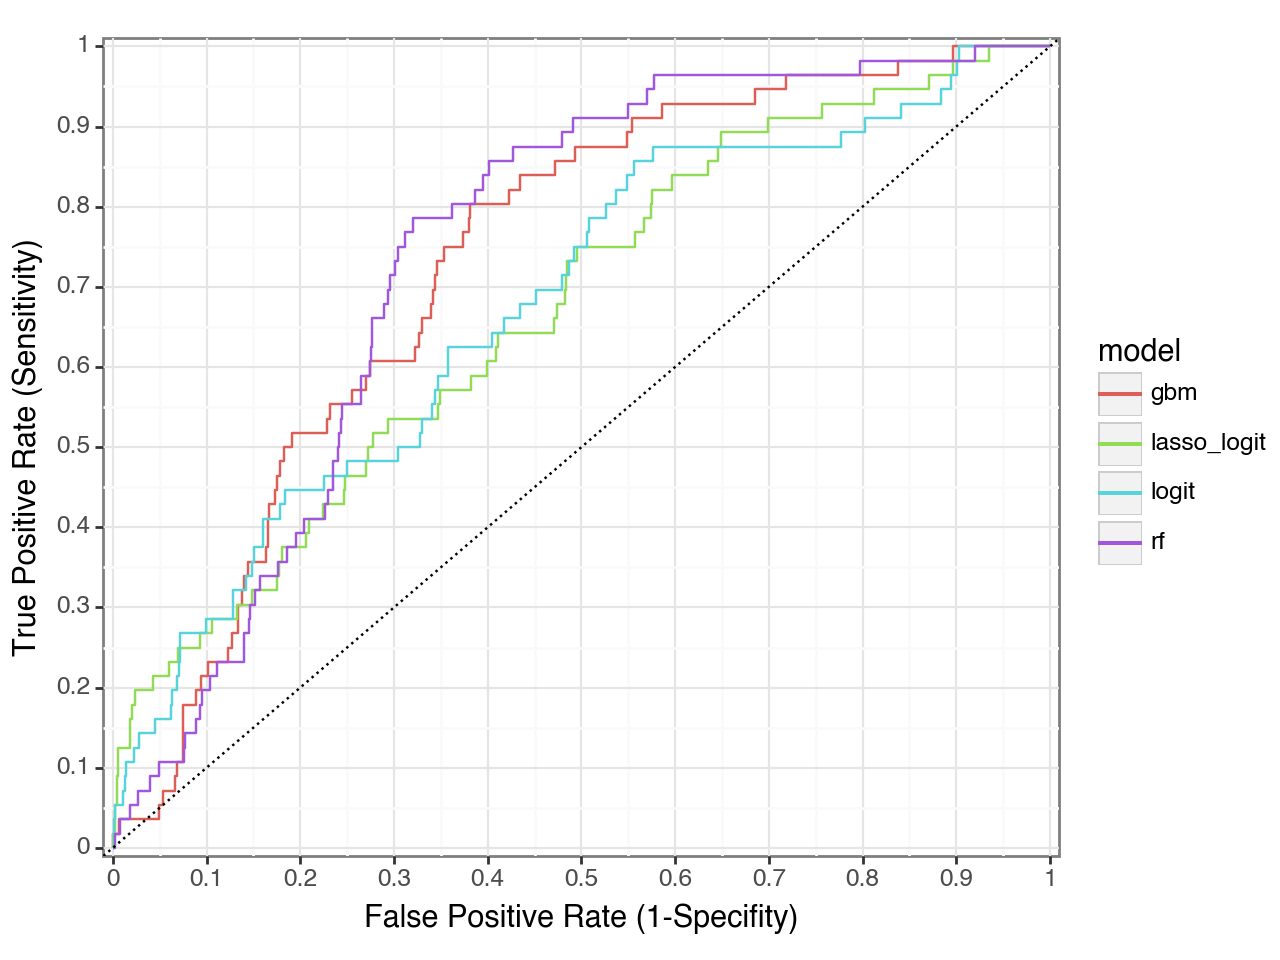

<Figure Size: (640 x 480)>

In [35]:
create_roc_plots(holdout_set.default, holdout_set[categorical_columns + numerical_columns], models)

Loss function

In [36]:
FP = 3
FN = 15
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = training_set.default.sum()/len(training_set.default)
prevelance

0.10133308473944252

In [37]:
# rmse
CV_RMSE_folds = dict()

# logit with brier score
brier_logit_pipe, brier_logit_search = get_logit_pipe(scoring='neg_brier_score')
brier_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

CV_RMSE_folds['logit'] = np.sqrt(-1 * brier_logit_search.scores_[1].ravel())

# lasso logit with breier score
brier_lasso_logit_pipe, brier_lasso_logit_search = get_lasso_logit_pipe(scoring='neg_brier_score')
brier_lasso_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

lambdas = list(10**np.arange(-1, -4.01, -1/3))
n_obs = training_set.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]
lasso_best_lambda = cv_summary(lambdas=lambdas, C_values=Cs_values, model=brier_lasso_logit_search).sort_values('mean_cv_score', ascending = False).iloc[0,0]
for i, l in enumerate(lambdas):
    if l == lasso_best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['lasso_logit'] = np.sqrt(-1*(brier_lasso_logit_search.scores_[1][:,i])).tolist()

# RF with brier score
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_search.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)

# GBM with brier score
CV_RMSE_folds["GBM"] = np.sqrt(
    pd.DataFrame(gbm_search.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)

pd.DataFrame(CV_RMSE_folds)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.3s
[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing interactions, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.1s
[Pipeline] ......... (step 4 of 4) Processing regressor, total= 1.7min


,logit,lasso_logit,RF,GBM
0,0.310592,0.299046,0.290527,0.294911
1,0.369691,0.290737,0.276443,0.284936
2,0.387091,0.282566,0.286489,0.290522
3,0.375702,0.291789,0.282657,0.279341
4,0.360720,0.292280,0.274498,0.270550


In [38]:
CV_AUC_folds = dict()

# logit with brier score
auc_logit_pipe, auc_logit_search = get_logit_pipe()
auc_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

CV_AUC_folds['logit'] = auc_logit_search.scores_[1].ravel()

# lasso logit with breier score
auc_lasso_logit_pipe, auc_lasso_logit_search = get_lasso_logit_pipe()
auc_lasso_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

lambdas = list(10**np.arange(-1, -4.01, -1/3))
n_obs = training_set.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]
lasso_best_lambda = cv_summary(lambdas=lambdas, C_values=Cs_values, model=auc_lasso_logit_search).sort_values('mean_cv_score', ascending = False).iloc[0,0]
for i, l in enumerate(lambdas):
    if l == lasso_best_lambda:
        best_lambda_i = i
        CV_AUC_folds['lasso_logit'] = (auc_lasso_logit_search.scores_[1][:,i]).tolist()

# RF with brier score
CV_AUC_folds["RF"] = pd.DataFrame(prob_forest_search.cv_results_).filter(like="_test_roc_auc").loc[lambda x: x["rank_test_roc_auc"] == 1].filter(like="split").values[0]

# GBM with brier score
CV_AUC_folds["GBM"] = pd.DataFrame(gbm_search.cv_results_).filter(like="_test_roc_auc").loc[lambda x: x["rank_test_roc_auc"] == 1].filter(like="split").values[0]

pd.DataFrame(CV_AUC_folds)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.6s
[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing interactions, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.0s
[Pipeline] ......... (step 4 of 4) Processing regressor, total= 1.7min


,logit,lasso_logit,RF,GBM
0,0.662901,0.666848,0.741049,0.730621
1,0.726255,0.750283,0.831724,0.803673
2,0.702657,0.786921,0.766220,0.697131
3,0.690565,0.754001,0.789637,0.828719
4,0.763340,0.759503,0.840655,0.852523


In [39]:
brier_lasso_logit_search.scores_

{1: array([[-0.10120364, -0.09339064, -0.08962461, -0.0887144 , -0.08904783,
         -0.08929862, -0.08942872, -0.08981391, -0.08982938, -0.09048368],
        [-0.10120364, -0.09339064, -0.08898542, -0.0863676 , -0.08506292,
         -0.08435605, -0.08452827, -0.0852949 , -0.08687398, -0.08786601],
        [-0.10097205, -0.09310477, -0.08905258, -0.0854211 , -0.08325359,
         -0.08064092, -0.07984335, -0.08022017, -0.08073809, -0.08312489],
        [-0.10097205, -0.09298876, -0.08985263, -0.0884883 , -0.08691789,
         -0.08640303, -0.08514095, -0.08463351, -0.08519711, -0.08546532],
        [-0.10097205, -0.09299312, -0.08980742, -0.08741309, -0.08661047,
         -0.08578746, -0.08542751, -0.08487437, -0.08513872, -0.08703801]])}

In [40]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

NameError: name 'logit_model_vars' is not defined